## Model Ensembling

Ensembling is an approach to combine the results of multiple models to create a single prediction. This helps improve generalizability and robustness over a single estimator. One example of this is a random forest or gradient boosted tree: however, you can ensemble other models together with other methods, such as voting. 
|
This example will go through how to create a simple voting ensemble model using three different classification models.

In [88]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import seaborn as sns

## Read and Explore

We'll be reading in a diabetes dataset that has various health metrics about people. For example, age, glucose, diet type, etc. We are going to use these variables to predict whether a person has diabetes or not.

In [17]:
df = pd.read_csv('https://github.com/stu-code/python-tips/raw/refs/heads/main/data/diabetes_dataset.csv')

In [18]:
df.head()

,Age,Pregnancies,BMI,Glucose,BloodPressure,HbA1c,LDL,HDL,Triglycerides,WaistCircumference,HipCircumference,WHR,FamilyHistory,DietType,Hypertension,MedicationUse,Outcome
0,69,5,28.39,130.1,77.0,5.4,130.4,44.0,50.0,90.5,107.9,0.84,0,0,0,1,0
1,32,1,26.49,116.5,72.0,4.5,87.4,54.2,129.9,113.3,81.4,1.39,0,0,0,0,0
2,89,13,25.34,101.0,82.0,4.9,112.5,56.8,177.6,84.7,107.2,0.79,0,0,0,1,0
3,78,13,29.91,146.0,104.0,5.7,50.7,39.1,117.0,108.9,110.0,0.99,0,0,0,1,1
4,38,8,24.56,103.2,74.0,4.7,102.5,29.1,145.9,84.1,92.8,0.91,0,1,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9538 entries, 0 to 9537
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 9538 non-null   int64  
 1   Pregnancies         9538 non-null   int64  
 2   BMI                 9538 non-null   float64
 3   Glucose             9538 non-null   float64
 4   BloodPressure       9538 non-null   float64
 5   HbA1c               9538 non-null   float64
 6   LDL                 9538 non-null   float64
 7   HDL                 9538 non-null   float64
 8   Triglycerides       9538 non-null   float64
 9   WaistCircumference  9538 non-null   float64
 10  HipCircumference    9538 non-null   float64
 11  WHR                 9538 non-null   float64
 12  FamilyHistory       9538 non-null   int64  
 13  DietType            9538 non-null   int64  
 14  Hypertension        9538 non-null   int64  
 15  MedicationUse       9538 non-null   int64  
 16  Outcom

<Axes: >

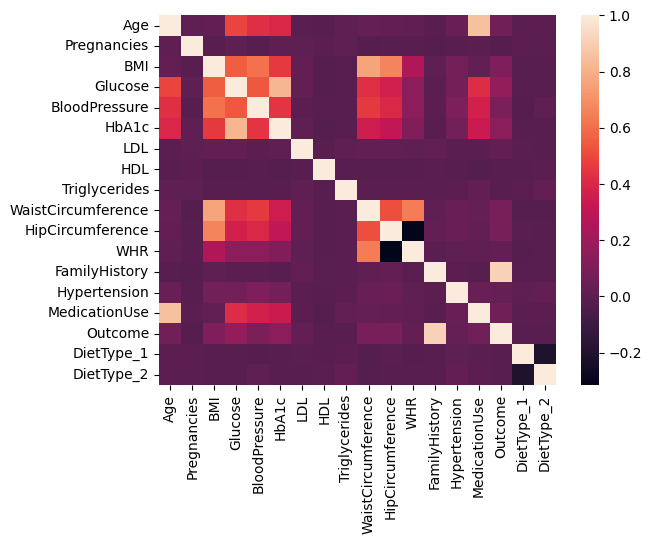

In [90]:
sns.heatmap(df.corr())

## Prepare the Data for Modeling

- Convert 1/0 columns to boolean (optional)
- Create dummy variables
- Create X and y
- Train/Test/Split
- Scale the data

In [20]:
binary_cols = [col for col in df.columns if set(df[col].unique()) == {0, 1}]
df[binary_cols] = df[binary_cols].astype(bool)

In [21]:
df = pd.get_dummies(df, columns=['DietType'], drop_first=True)

Note: Family History is an extremely strong predictor on its own. Normally we would keep it, but for this example we'll drop it so we can better see how ensemble works.

In [126]:
y = df['Outcome']
X = df.drop(['Outcome', 'FamilyHistory'], axis=1) 

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [111]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

## Define and Fit four models
1. Logistic Regression
2. MLP Neural Network
3. Decision Tree
4. Ensemble of all three

We will be using hard voting for ensembling, which means we will choose the most common prediction. For example:
- Logistic Regression: 1
- MLP Neural Network:  1
- Decision Tree:       0

The ensemble prediction would be 1.

In [130]:
logreg_model   = LogisticRegression(max_iter=5000, random_state=42)
mlp_model      = MLPClassifier(hidden_layer_sizes=(50, 5), random_state=42)
tree_model     = DecisionTreeClassifier(random_state=42)
ensemble_model = VotingClassifier(
    estimators=[('lr', logreg_model), ('mlp', mlp_model), ('tree', tree_model)],
    voting='hard'
)

In [131]:
logreg_model.fit(X_train, y_train)
mlp_model.fit(X_train, y_train)
tree_model.fit(X_train, y_train)
ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=5000,
                                                 random_state=42)),
                             ('mlp',
                              MLPClassifier(hidden_layer_sizes=(50, 5),
                                            random_state=42)),
                             ('tree', DecisionTreeClassifier(random_state=42))])

## Check Performance

See how each model performed. Did the ensembling approach improve accuracy?

In [132]:
models = {'Logistic Regression': logreg_model,
          'MLP Neural Network': mlp_model,
          'Decision Tree': tree_model,
          'Ensemble': ensemble_model
         } 

for model_name, model in models.items():
    print(f"Classification report for {model_name}")
    print(classification_report(y_test, model.predict(X_test)))
    print("="*50)

Classification report for Logistic Regression
              precision    recall  f1-score   support

       False       0.68      0.99      0.81      2498
        True       0.91      0.10      0.19      1318

    accuracy                           0.69      3816
   macro avg       0.79      0.55      0.50      3816
weighted avg       0.76      0.69      0.59      3816

Classification report for MLP Neural Network
              precision    recall  f1-score   support

       False       0.66      0.93      0.77      2498
        True       0.43      0.10      0.17      1318

    accuracy                           0.64      3816
   macro avg       0.55      0.52      0.47      3816
weighted avg       0.58      0.64      0.56      3816

Classification report for Decision Tree
              precision    recall  f1-score   support

       False       0.69      0.67      0.68      2498
        True       0.41      0.43      0.42      1318

    accuracy                           0.59      38